## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'spaceNet-full' 
TRANSFORM = 'fourier'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_fourier_full_spaceNet.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = True
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/spaceNet/full/fourier/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 47614,
 3: 54416,
 4: 61218,
 5: 102030,
 6: 156446,
 7: 197258,
 8: 326496,
 9: 421724,
 10: 639388,
 11: 904666,
 12: 1312786,
 13: 1904560,
 14: 2727602,
 15: 3958764,
 16: 5720482,
 17: 8298440,
 18: 11957916,
 19: 17270278,
 20: 25140192,
 21: 36322680,
 22: 52586262,
 23: 65734528,
 24: 32003410}

Running 12760 CDFs


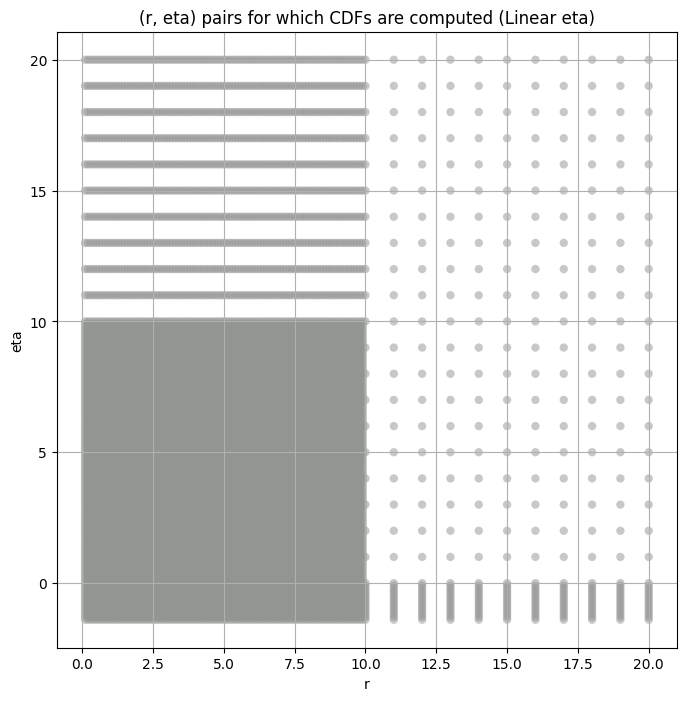

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 17


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 20


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 23


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1313.120000  1220.493700  1412.585300    6.068365    4.379918   
5      533.579040   487.300300   586.624450   10.865308    6.509176   
8      152.255700   138.976060   167.494960   10.892404    6.435522   
11      37.265316    34.162117    40.700905    9.679420    6.116399   
14      10.825041     9.897249    11.943296   11.137888    6.328707   
17       2.667430     2.387082     3.338226   39.640400    7.007048   
20       0.443403     0.378769     0.739939  218.225190    7.204465   
23       0.105539     0.095510     0.133839   39.834950    4.945594   

      kurt_upper  total_samples  
band                             
2       8.609890        47614.0  
5      17.420868       102030.0  
8      23.173120       326496.0  
11     17.178192       904666.0  
14     29.539549      2727602.0  
17    239.846470      8298440.0  
20    976.404540     25140192.0  
23    243.447360     65734528.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                               
2     1313.120000    1313.119995     1249.506348     1208.793335   
5      533.579040     533.579041      508.822449      495.274719   
8      152.255700     152.255707      145.498444      141.800201   
11      37.265316      37.265316       35.733829       34.895638   
14      10.825041      10.825041       10.368007       10.124291   
17       2.667430       2.667430        2.499081        2.434537   
20       0.443403       0.443403        0.395685        0.384962   
23       0.105539       0.105539        0.099757        0.097737   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2        1177.060547      1149.377441      1102.510742      1063.160767   
5         484.571136       475.548126       460.595398       448.428925   
8         138.872574       136.374924       132.181915       128.631088   
11         34.217422        33.631119        32.629761        31.781830   
14          9.926456         9.754682         9.461452         9.210648   
17          2.383035         2.338931         2.264084         2.200744   
20          0.376566         0.369426         0.357414         0.347317   
23          0.096080         0.094629         0.092118         0.089955   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2         1029.394287       999.459656       972.370056       903.326050  
5          437.840332       428.272644       419.533142       396.987488  
8          125.514984       122.736488       120.206482       113.658264  
11          31.034458        30.359978        29.740793        28.130465  
14           8.989103         8.789097         8.605572         8.128005  
17           2.145122         2.095117         2.049536         1.931920  
20           0.338480         0.330559         0.323343         0.304742  
23           0.088026         0.086274         0.084661         0.080433

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.008039059809459292 1313.12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.008214843134026928 1249.5063


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.007198080990195949 1208.7933


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.006678864937405091 1177.0605


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.006649118989705272 1149.3774


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.0066780726628028475 1102.5107


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.006705599188446043 1063.1608


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.007809912221897863 1029.3943


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.008885297934088376 999.45966


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.009793869618527684 972.37006


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.013385183037271764 903.32605
Number of samples: 47614, Without approximation : 47614.0


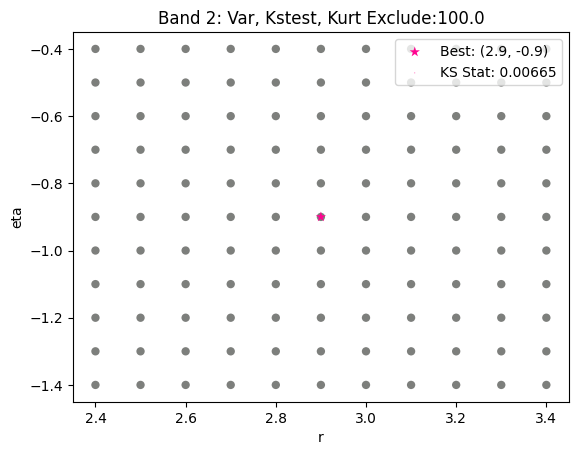

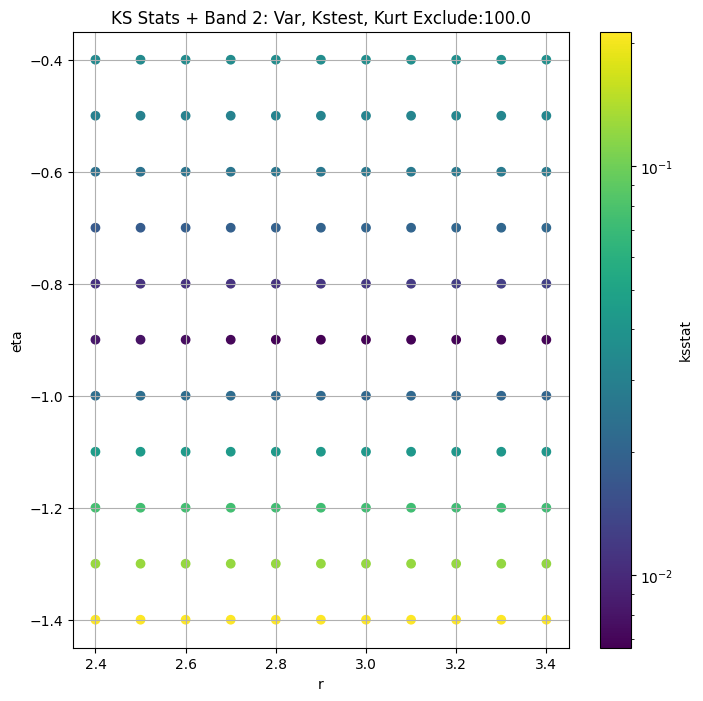

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.010445673587283988 533.57904


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.010462536490459362 508.82245


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.009459264724405655 495.27472


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.009760098934981518 484.57114


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.008697624677611426 475.54813


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.008827765359994133 460.5954


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.008939654077852244 448.42892


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.009004429720771645 437.84033


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.008837939633711267 428.27264


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.008906453521743352 419.53314


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.008986312383510164 396.9875
Number of samples: 100000, Without approximation : 102030.0


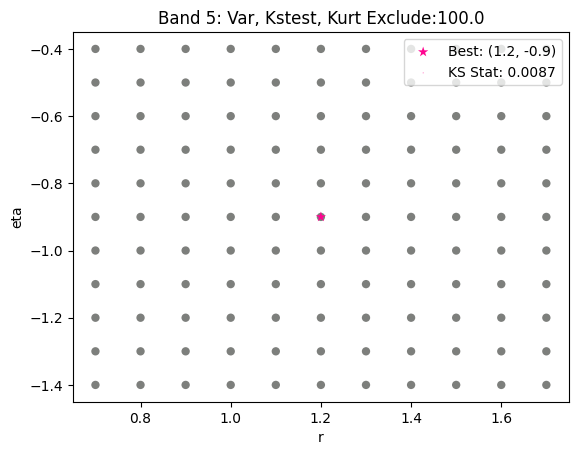

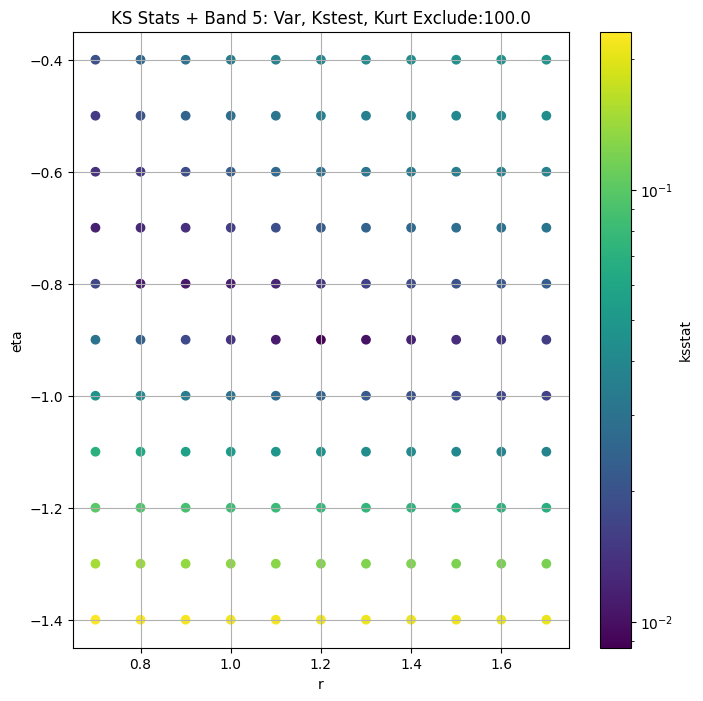

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.009082994359420393 152.2557


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.009683830297507967 145.49844


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.009212133745470807 141.8002


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.00907777475671434 138.87257


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.008959853331733991 136.37492


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.008925172162465134 132.18192


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.008054283588415201 128.63109


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.007616947030374188 125.514984


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.007740282754762351 122.73649


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.007753996795353768 120.20648


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.007827444552099161 113.658264
Number of samples: 100000, Without approximation : 326496.0


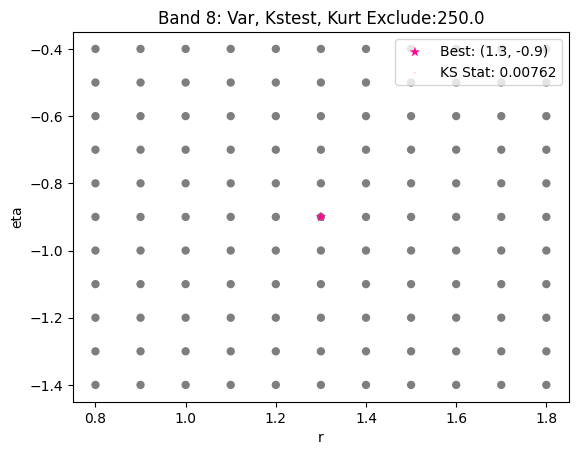

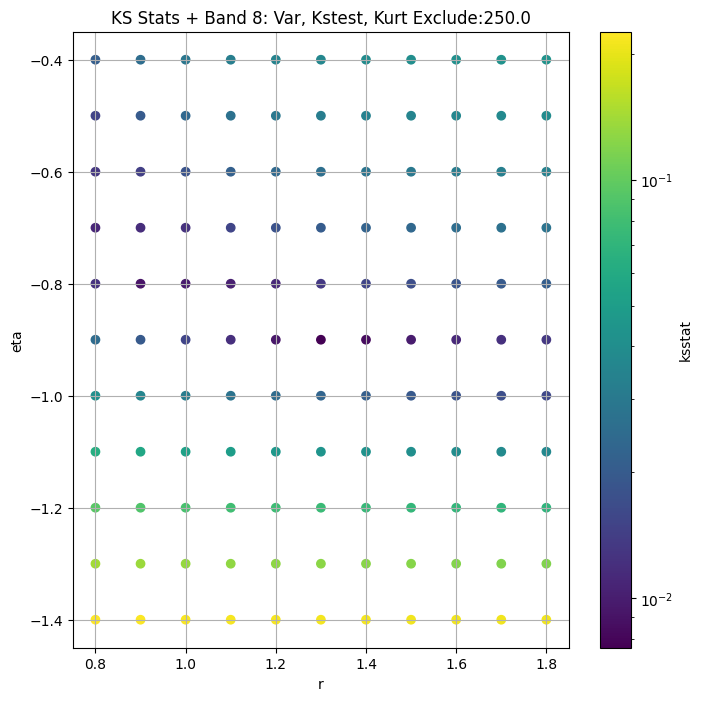

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.007968673117639713 37.265316


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.008672332115352899 35.73383


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.00857734397056542 34.895638


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.008405204025306534 34.217422


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.008260800001049673 33.63112


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.00801574743785638 32.62976


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.006921112106879623 31.78183


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.006785529916835342 31.034458


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.006935982224110071 30.359978


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.006765419560878061 29.740793


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.0077882065514025545 28.130465
Number of samples: 100000, Without approximation : 904666.0


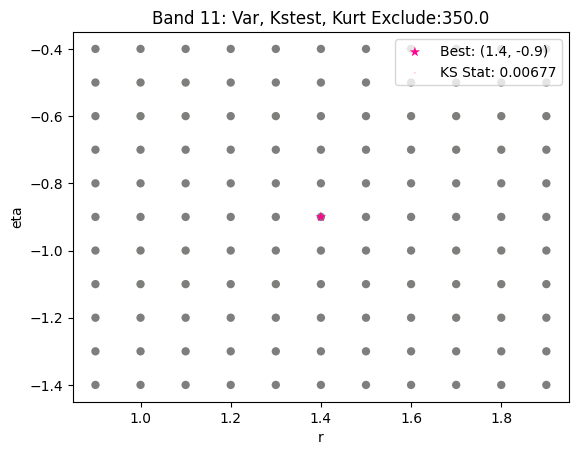

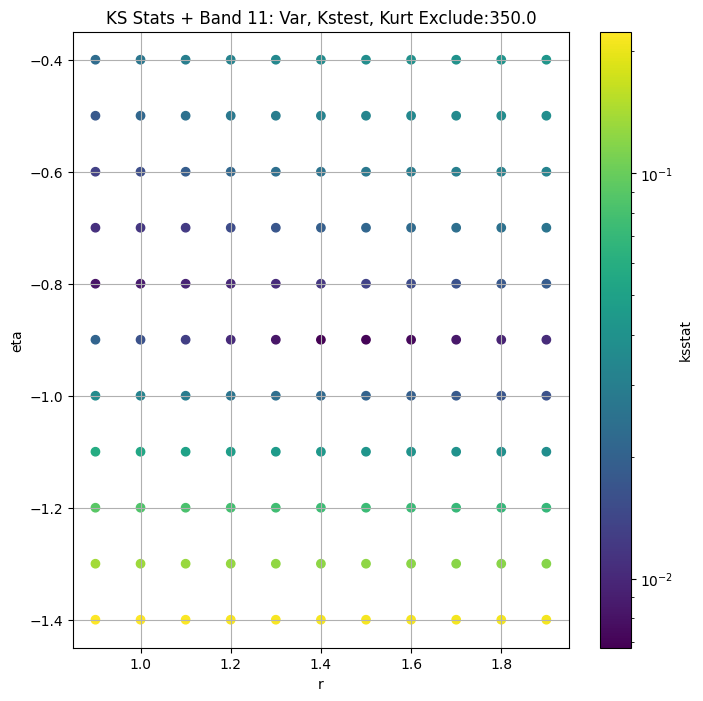

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.0076614253253838305 10.825041


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.008294864172048833 10.368007


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.007110372969370393 10.124291


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.005586812400878743 9.926456


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.006492097787731188 9.754682


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.006816471390614143 9.461452


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.006283588466847179 9.210648


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.006008934341232841 8.989103


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.006055300362468041 8.789097


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.006232621174130926 8.605572


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.008064028853028038 8.128005
Number of samples: 100000, Without approximation : 2727602.0


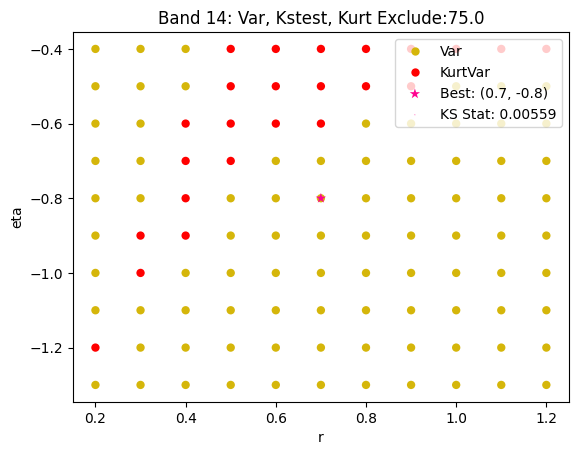

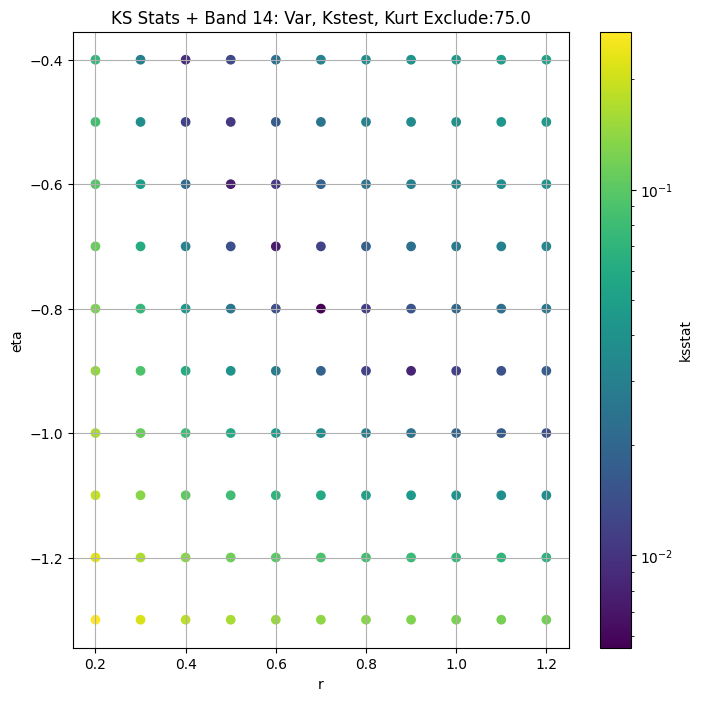

####
Band  17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 0 0.006004016314019034 2.66743


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 25 0.005071765041186782 2.4990807


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 50 0.0045694677283467655 2.434537


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 75 0.005524589106847555 2.3830354


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 100 0.0054029551056359315 2.3389306


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 150 0.0054960209812722205 2.2640843


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 200 0.004949769976565044 2.2007437


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 250 0.0049820604987492745 2.1451218


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 300 0.005572287075873872 2.0951169


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 350 0.00618033668374629 2.049536


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 500 0.007935672672134464 1.9319199
Number of samples: 100000, Without approximation : 8298440.0


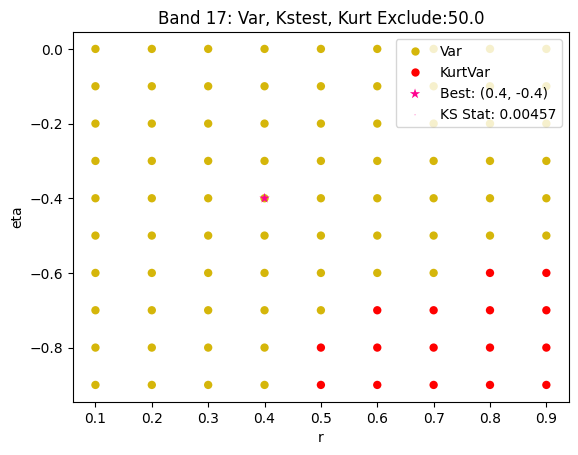

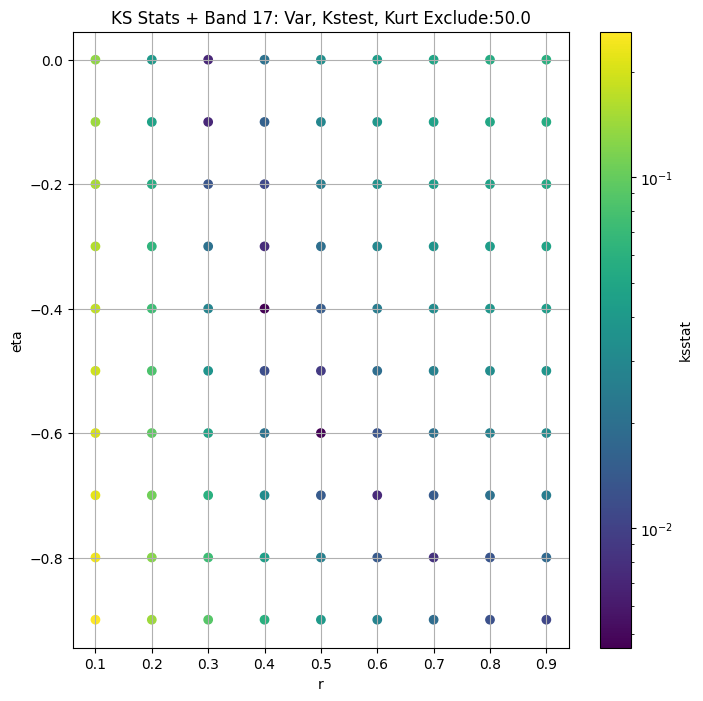

####
Band  20


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 0 0.003472305597358963 0.44340265


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 25 0.0019439130691839973 0.39568463


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 50 0.002356367077511079 0.38496226


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 75 0.002966948711568884 0.37656626


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 100 0.0030700394672026343 0.36942577


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 150 0.003682488045329002 0.357414


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 200 0.0043210297728498714 0.34731674


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 250 0.005030558693714937 0.3384797


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 300 0.005628359909688019 0.33055902


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 350 0.006228174409821485 0.32334265


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 500 0.00798126582064107 0.3047416
Number of samples: 100000, Without approximation : 25140192.0


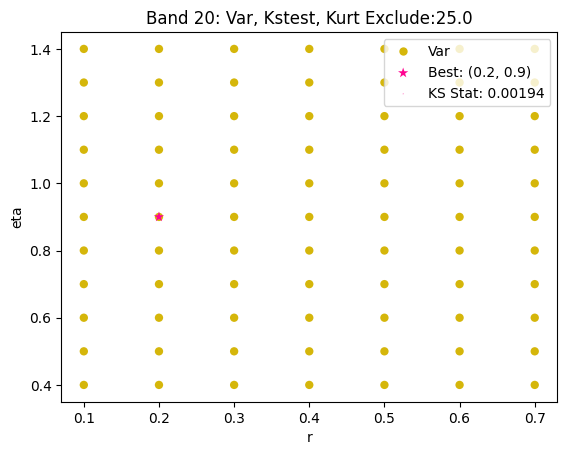

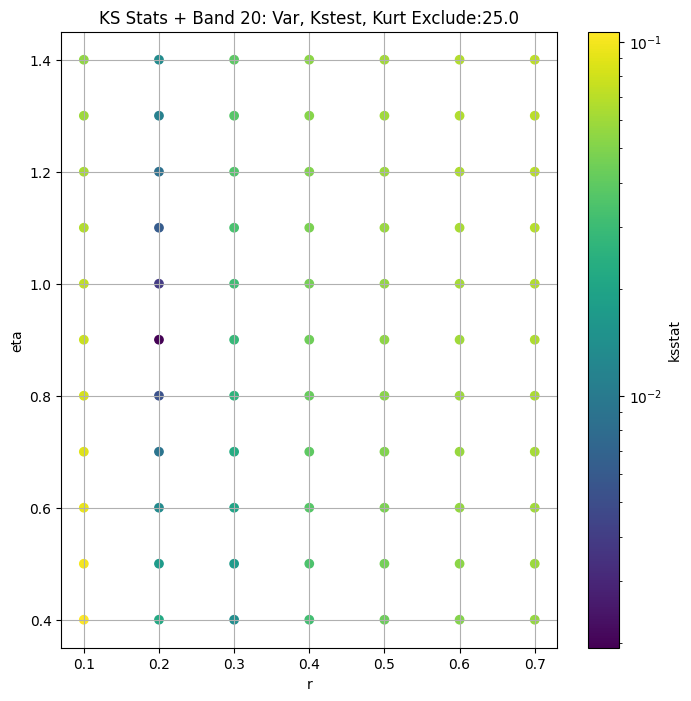

####
Band  23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 0 0.002557292293341229 0.1055389


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 25 0.002180135755223911 0.099756874


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 50 0.0024035597265987807 0.09773726


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 75 0.0029222601742007193 0.09607985


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 100 0.0033071568947972974 0.09462853


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 150 0.0038298210137683864 0.092118256


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 200 0.00445674393639095 0.08995459


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 250 0.005042199407468861 0.088026345


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 300 0.005640456422404516 0.08627411


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 350 0.006206794324412956 0.08466055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 500 0.00793801476697742 0.08043302
Number of samples: 100000, Without approximation : 65734528.0


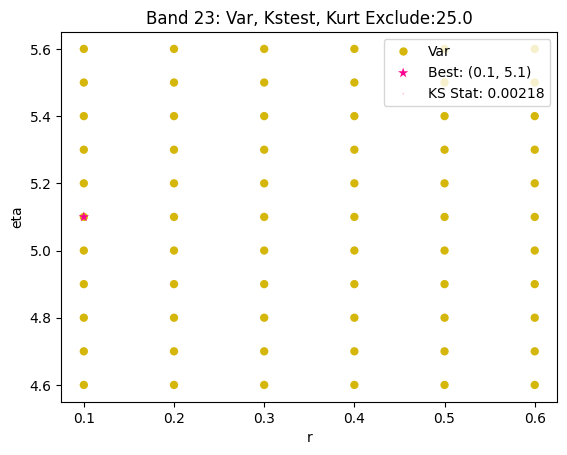

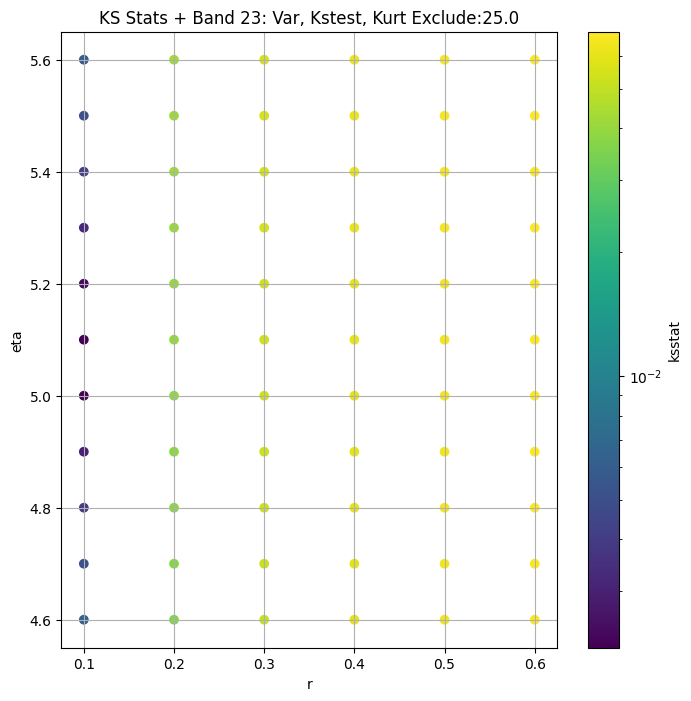

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1313.120000  1220.493700  1412.585300    6.068365    4.379918   
5      533.579040   487.300300   586.624450   10.865308    6.509176   
8      152.255700   138.976060   167.494960   10.892404    6.435522   
11      37.265316    34.162117    40.700905    9.679420    6.116399   
14      10.825041     9.897249    11.943296   11.137888    6.328707   
17       2.667430     2.387082     3.338226   39.640400    7.007048   
20       0.443403     0.378769     0.739939  218.225190    7.204465   
23       0.105539     0.095510     0.133839   39.834950    4.945594   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       8.609890        47614.0             0.006649        2.9         -0.9   
5      17.420868       102030.0             0.008698        1.2         -0.9   
8      23.173120       326496.0             0.007617        1.3         -0.9   
11     17.178192       904666.0             0.006765        1.4         -0.9   
14     29.539549      2727602.0             0.005587        0.7         -0.8   
17    239.846470      8298440.0             0.004569        0.4         -0.4   
20    976.404540     25140192.0             0.001944        0.2          0.9   
23    243.447360     65734528.0             0.002180        0.1          5.1   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      3.159379e+03                   100.0         1149.377400   
5      9.439042e+02                   100.0          475.548130   
8      2.644900e+02                   250.0          125.514984   
11     6.573334e+01                   350.0           29.740793   
14     7.841896e+00                    75.0            9.926456   
17     1.112022e-01                    50.0            2.434537   
20     7.548928e-07                    25.0            0.395685   
23     3.316358e-20                    25.0            0.099757   

      kstest_stat_cutoff_0.05  
band                           
2                    0.006220  
5                    0.004250  
8                    0.002376  
11                   0.001428  
14                   0.000822  
17                   0.000471  
20                   0.000271  
23                   0.000168

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
band 2, 100.0 + 100 = 200, ksstat: 0.007398455992357111, var: 1063.1607666015625


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
band 2, 100.0 + 75 = 175, ksstat: 0.0071021978674125075, var: 1082.0965576171875


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
band 2, 100.0 + 50 = 150, ksstat: 0.007223566013659921, var: 1102.5107421875


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
band 2, 100.0 + 25 = 125, ksstat: 0.006693722897141097, var: 1124.7471923828125


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
band 2, 100.0 + 0 = 100, ksstat: 0.006649118989705272, var: 1149.37744140625


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
band 2, 100.0 + -25 = 75, ksstat: 0.006678864937405091, var: 1177.060546875


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
band 2, 100.0 + -50 = 50, ksstat: 0.00884438175906846, var: 1208.7933349609375


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
band 2, 100.0 + -75 = 25, ksstat: 0.010456501849419708, var: 1249.50634765625


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
band 2, 100.0 + -100 = 0, ksstat: 0.013007332992042708, var: 1313.1199951171875
Number of samples: 47614, Without approximation : 47614.0


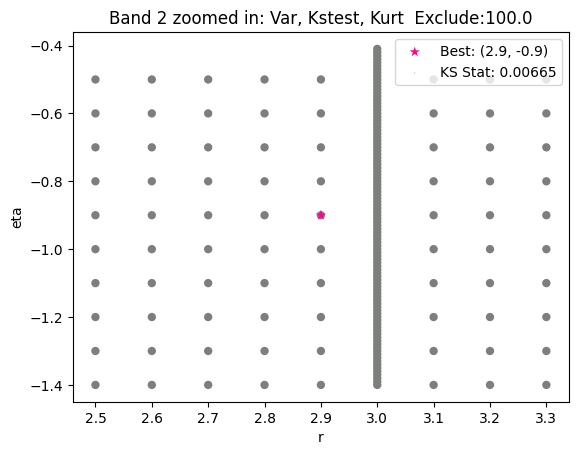

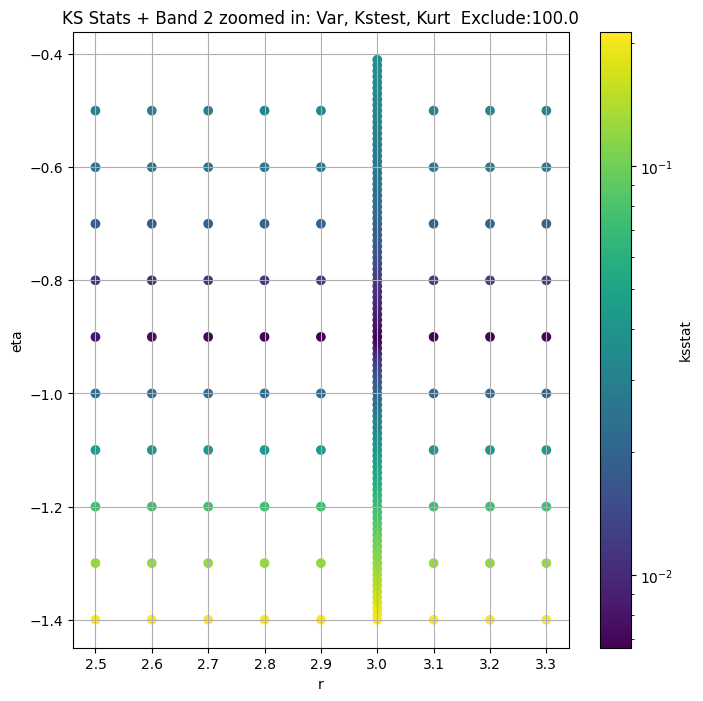

Band 5


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 5, 100.0 + 100 = 200, ksstat: 0.008513164474424295, var: 448.4289245605469


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 5, 100.0 + 75 = 175, ksstat: 0.008386008726847693, var: 454.2677307128906


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 5, 100.0 + 50 = 150, ksstat: 0.008693247272166804, var: 460.59539794921875


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 5, 100.0 + 25 = 125, ksstat: 0.008710490200593224, var: 467.5669860839844


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 5, 100.0 + 0 = 100, ksstat: 0.008697624677611426, var: 475.5481262207031


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 5, 100.0 + -25 = 75, ksstat: 0.008812012685864914, var: 484.5711364746094


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 5, 100.0 + -50 = 50, ksstat: 0.009240006720015306, var: 495.27471923828125


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 5, 100.0 + -75 = 25, ksstat: 0.00922206071698406, var: 508.82244873046875


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 5, 100.0 + -100 = 0, ksstat: 0.009578727251306915, var: 533.5790405273438
Number of samples: 100000, Without approximation : 102030.0


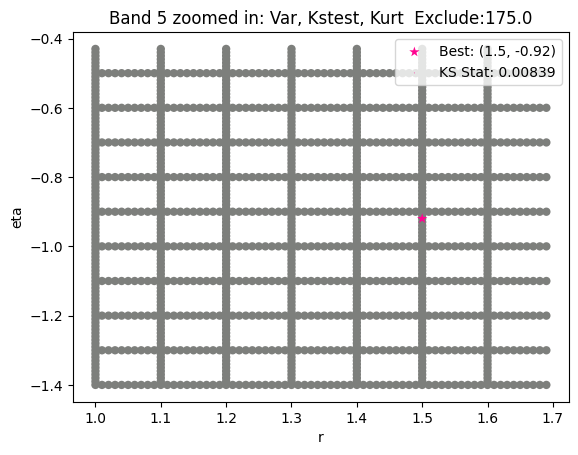

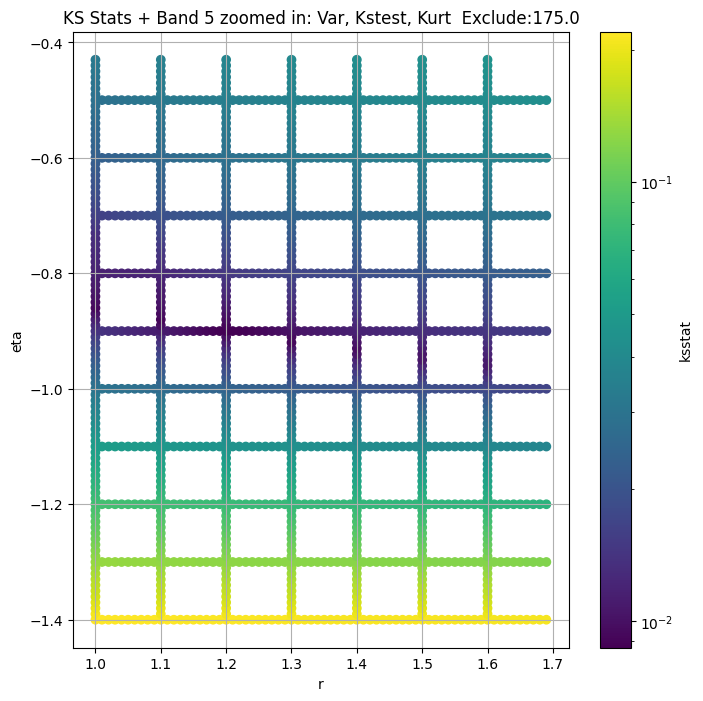

Band 8


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 8, 250.0 + 100 = 350, ksstat: 0.007380108386548123, var: 120.20648193359375


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 8, 250.0 + 75 = 325, ksstat: 0.007277156932237072, var: 121.4446029663086


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 8, 250.0 + 50 = 300, ksstat: 0.007570761939292403, var: 122.73648834228516


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 8, 250.0 + 25 = 275, ksstat: 0.007410594585632979, var: 124.09064483642578


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 8, 250.0 + 0 = 250, ksstat: 0.007586347878364652, var: 125.51498413085938


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 8, 250.0 + -25 = 225, ksstat: 0.007572994816118839, var: 127.02050018310547


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 8, 250.0 + -50 = 200, ksstat: 0.007558768076267763, var: 128.63108825683594


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 8, 250.0 + -75 = 175, ksstat: 0.007583528688546504, var: 130.3457489013672


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 8, 250.0 + -100 = 150, ksstat: 0.007823777790189057, var: 132.18191528320312
Number of samples: 100000, Without approximation : 326496.0


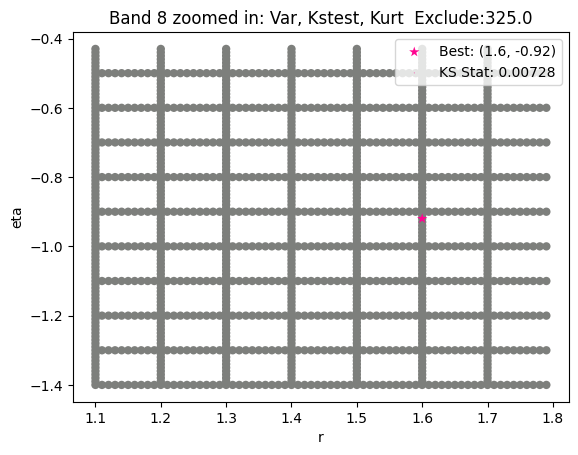

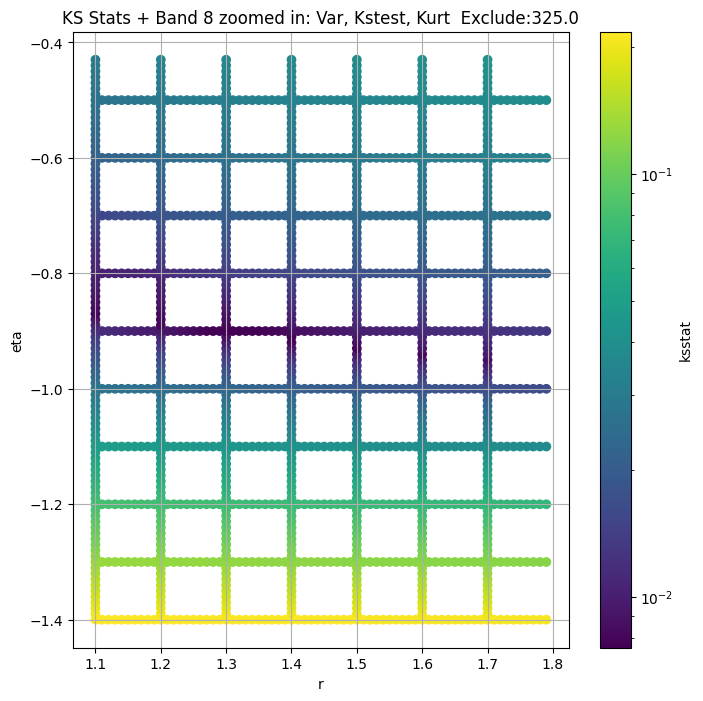

Band 11


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
band 11, 350.0 + 100 = 450, ksstat: 0.007157620795760655, var: 28.63245964050293


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
band 11, 350.0 + 75 = 425, ksstat: 0.006922425797639797, var: 28.89542579650879


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
band 11, 350.0 + 50 = 400, ksstat: 0.006720159585299035, var: 29.167238235473633


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
band 11, 350.0 + 25 = 375, ksstat: 0.006477061360117609, var: 29.449203491210938


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
band 11, 350.0 + 0 = 350, ksstat: 0.006540583422898982, var: 29.740793228149414


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
band 11, 350.0 + -25 = 325, ksstat: 0.006659215648440409, var: 30.044151306152344


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
band 11, 350.0 + -50 = 300, ksstat: 0.006709254976800971, var: 30.35997772216797


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
band 11, 350.0 + -75 = 275, ksstat: 0.006557356479290344, var: 30.68878746032715


  0%|          | 0/1900 [00:00<?, ?it/s]

Finding Minimum after computing 1900 CDFs
band 11, 350.0 + -100 = 250, ksstat: 0.006672980514117577, var: 31.03445816040039
Number of samples: 100000, Without approximation : 904666.0


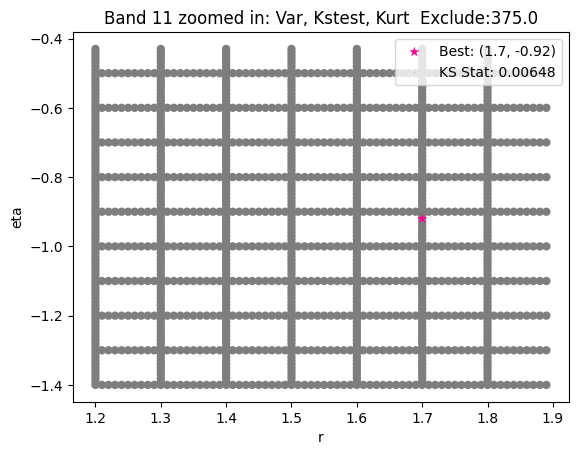

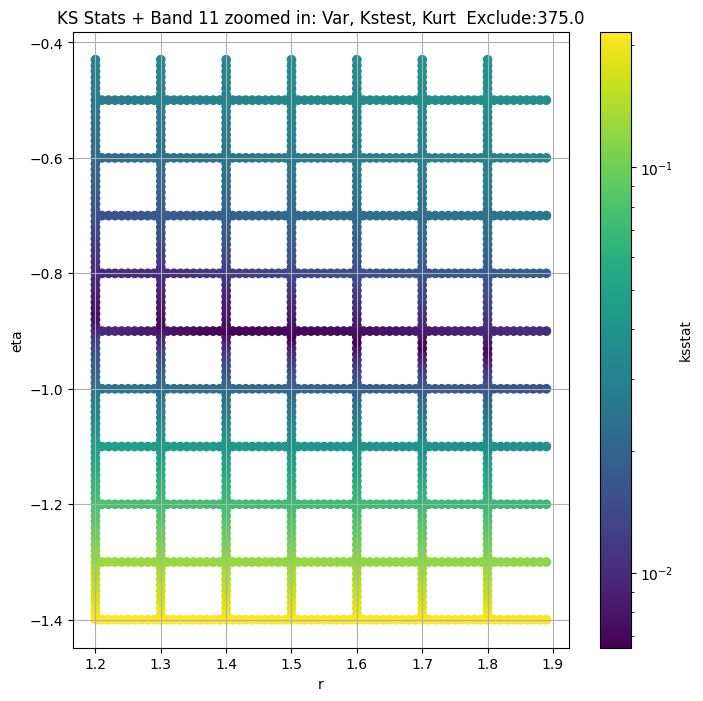

Band 14


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 14, 75.0 + 100 = 175, ksstat: 0.005545055945513688, var: 9.331765174865723


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 14, 75.0 + 75 = 150, ksstat: 0.005454579655377545, var: 9.461451530456543


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 14, 75.0 + 50 = 125, ksstat: 0.005693979060622745, var: 9.60147762298584


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 14, 75.0 + 25 = 100, ksstat: 0.00570310981115163, var: 9.754681587219238


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 14, 75.0 + 0 = 75, ksstat: 0.005586812400878743, var: 9.926456451416016


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 14, 75.0 + -25 = 50, ksstat: 0.005928870392833324, var: 10.12429141998291


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 14, 75.0 + -50 = 25, ksstat: 0.006013871415440408, var: 10.368006706237793


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
band 14, 75.0 + -75 = 0, ksstat: 0.00648560928250741, var: 10.825040817260742
Number of samples: 100000, Without approximation : 2727602.0


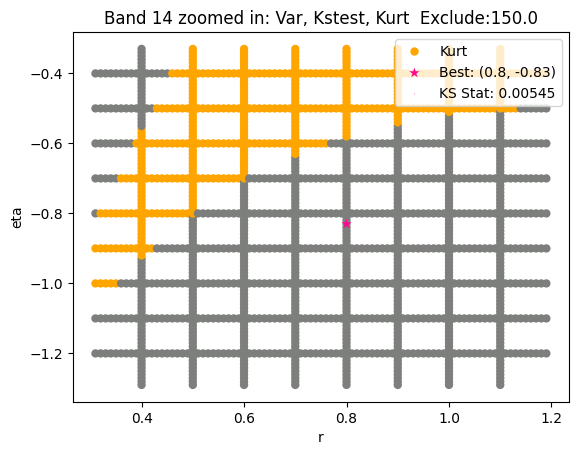

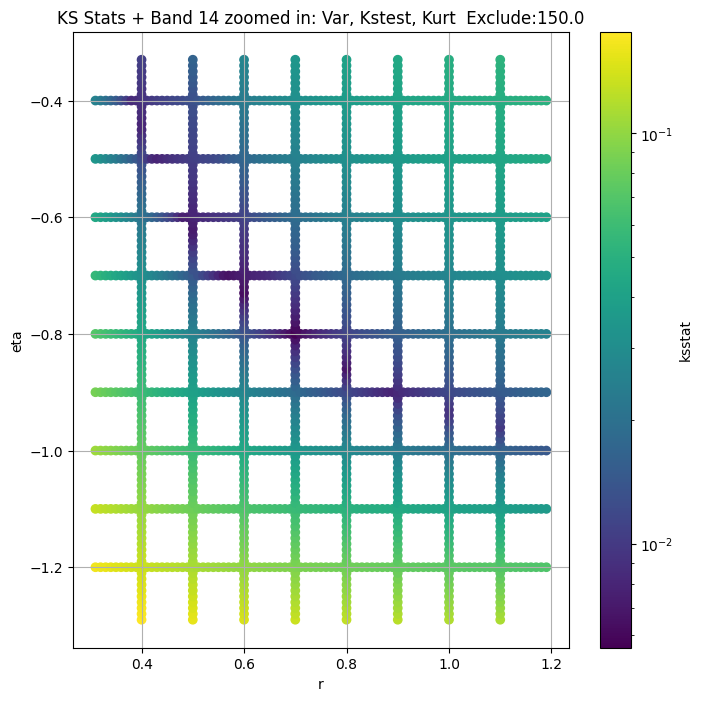

Band 17


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
band 17, 50.0 + 100 = 150, ksstat: 0.0037483812391405635, var: 2.2640843391418457


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
band 17, 50.0 + 75 = 125, ksstat: 0.003763469257277441, var: 2.29970121383667


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
band 17, 50.0 + 50 = 100, ksstat: 0.0037296050567232897, var: 2.338930606842041


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
band 17, 50.0 + 25 = 75, ksstat: 0.003917588416746581, var: 2.38303542137146


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
band 17, 50.0 + 0 = 50, ksstat: 0.004261050636751418, var: 2.434536933898926


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
band 17, 50.0 + -25 = 25, ksstat: 0.004367006835548359, var: 2.4990806579589844


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
band 17, 50.0 + -50 = 0, ksstat: 0.004796389248345578, var: 2.6674299240112305
Number of samples: 100000, Without approximation : 8298440.0


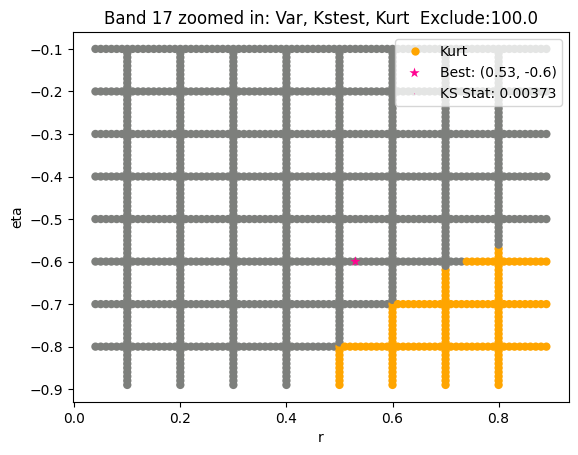

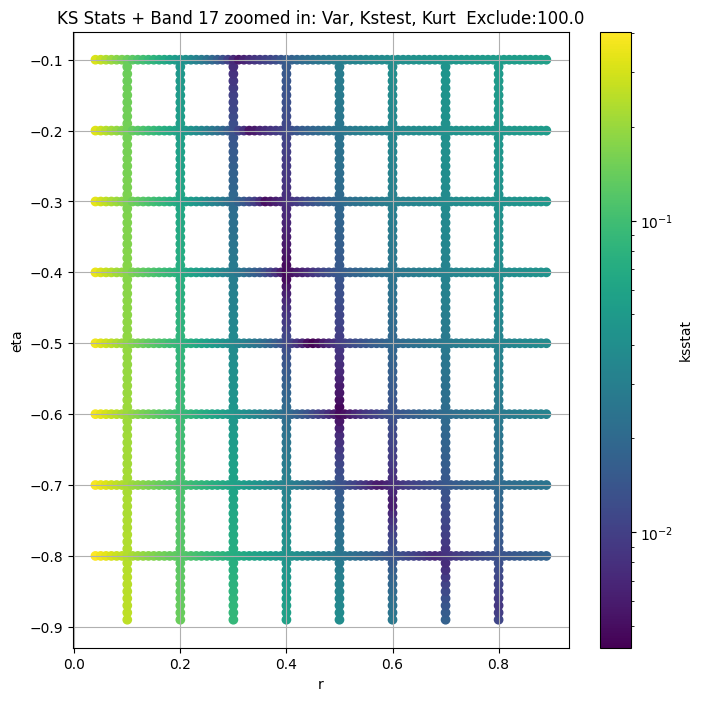

Band 20


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 20, 25.0 + 100 = 125, ksstat: 0.003701761326468156, var: 0.3631170094013214


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 20, 25.0 + 75 = 100, ksstat: 0.0032346975647358223, var: 0.36942577362060547


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 20, 25.0 + 50 = 75, ksstat: 0.0027298057972620082, var: 0.3765662610530853


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 20, 25.0 + 25 = 50, ksstat: 0.002356367077511079, var: 0.384962260723114


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 20, 25.0 + 0 = 25, ksstat: 0.0018173245721634784, var: 0.3956846296787262


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 20, 25.0 + -25 = 0, ksstat: 0.004226577769215853, var: 0.44340264797210693
Number of samples: 100000, Without approximation : 25140192.0


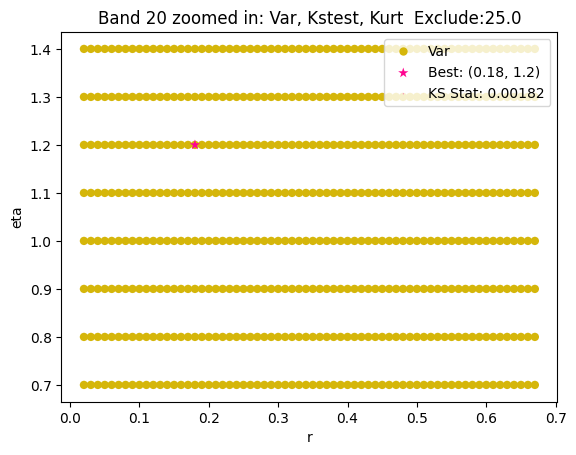

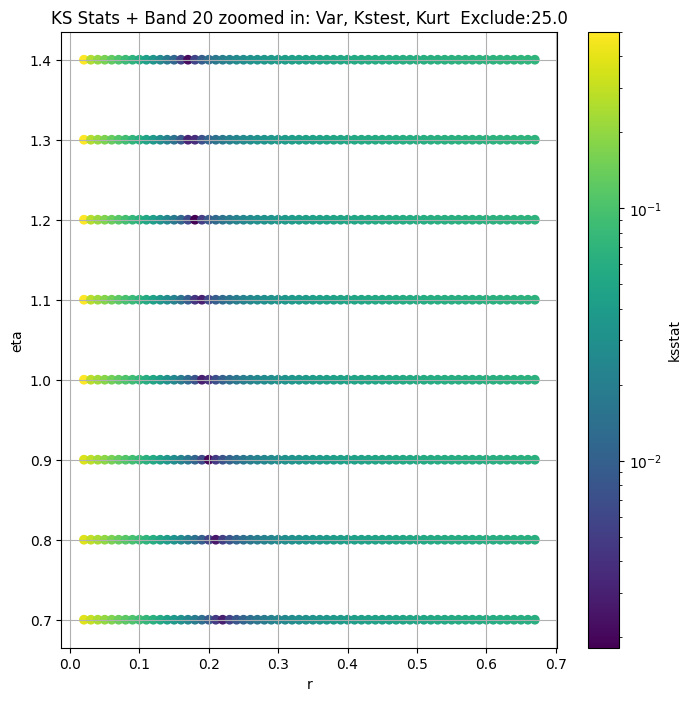

Band 23


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 23, 25.0 + 100 = 125, ksstat: 0.004226903192065756, var: 0.09331949800252914


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 23, 25.0 + 75 = 100, ksstat: 0.003803916621379466, var: 0.09462852776050568


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 23, 25.0 + 50 = 75, ksstat: 0.0033019385081545227, var: 0.09607984870672226


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 23, 25.0 + 25 = 50, ksstat: 0.0027574261267795386, var: 0.09773726016283035


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 23, 25.0 + 0 = 25, ksstat: 0.002180135755223911, var: 0.0997568741440773


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 23, 25.0 + -25 = 0, ksstat: 0.002481300266700126, var: 0.10553889721632004
Number of samples: 100000, Without approximation : 65734528.0


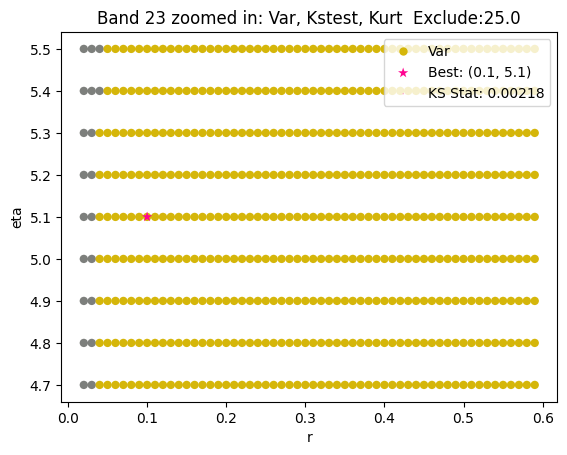

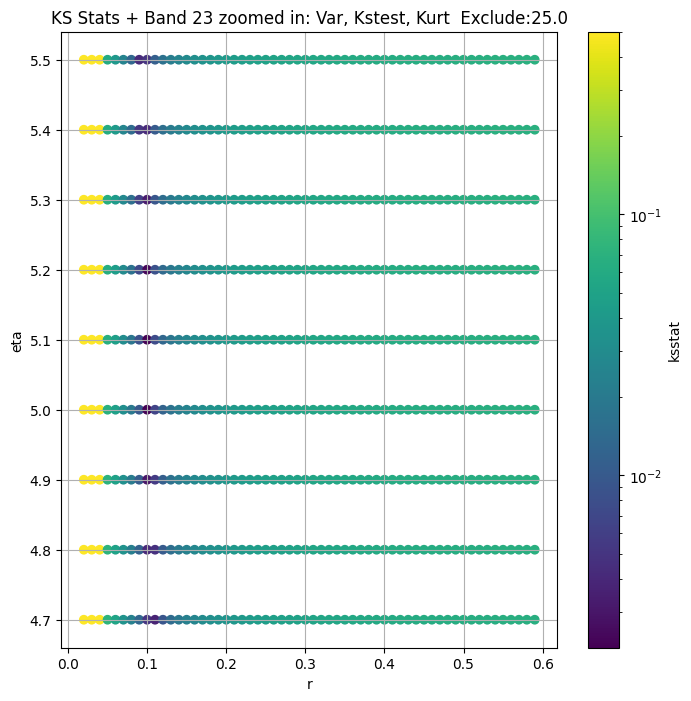

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1313.120000  1220.493700  1412.585300    6.068365    4.379918   
5      533.579040   487.300300   586.624450   10.865308    6.509176   
8      152.255700   138.976060   167.494960   10.892404    6.435522   
11      37.265316    34.162117    40.700905    9.679420    6.116399   
14      10.825041     9.897249    11.943296   11.137888    6.328707   
17       2.667430     2.387082     3.338226   39.640400    7.007048   
20       0.443403     0.378769     0.739939  218.225190    7.204465   
23       0.105539     0.095510     0.133839   39.834950    4.945594   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       8.609890        47614.0             0.006649        2.9         -0.9   
5      17.420868       102030.0             0.008698        1.2         -0.9   
8      23.173120       326496.0             0.007617        1.3         -0.9   
11     17.178192       904666.0             0.006765        1.4         -0.9   
14     29.539549      2727602.0             0.005587        0.7         -0.8   
17    239.846470      8298440.0             0.004569        0.4         -0.4   
20    976.404540     25140192.0             0.001944        0.2          0.9   
23    243.447360     65734528.0             0.002180        0.1          5.1   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      3.159379e+03                   100.0         1149.377400   
5      9.439042e+02                   100.0          454.267731   
8      2.644900e+02                   250.0          121.444603   
11     6.573334e+01                   350.0           29.449203   
14     7.841896e+00                    75.0            9.461452   
17     1.112022e-01                    50.0            2.338931   
20     7.548928e-07                    25.0            0.395685   
23     3.316358e-20                    25.0            0.099757   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.006220          0.006649    2.90     -0.90   
5                    0.004250          0.008386    1.50     -0.92   
8                    0.002376          0.007277    1.60     -0.92   
11                   0.001428          0.006477    1.70     -0.92   
14                   0.000822          0.005455    0.80     -0.83   
17                   0.000471          0.003730    0.53     -0.60   
20                   0.000271          0.001817    0.18      1.20   
23                   0.000168          0.002180    0.10      5.10   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     3.159379e+03                100.0        40173  
5     1.073501e+03                175.0        25507  
8     2.959715e+02                325.0        34434  
11    7.361420e+01                375.0        42405  
14    1.022932e+01                150.0        63927  
17    5.813957e-01                100.0       129663  
20    5.401900e-08                 25.0       589222  
23    3.316358e-20                 25.0       385162

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

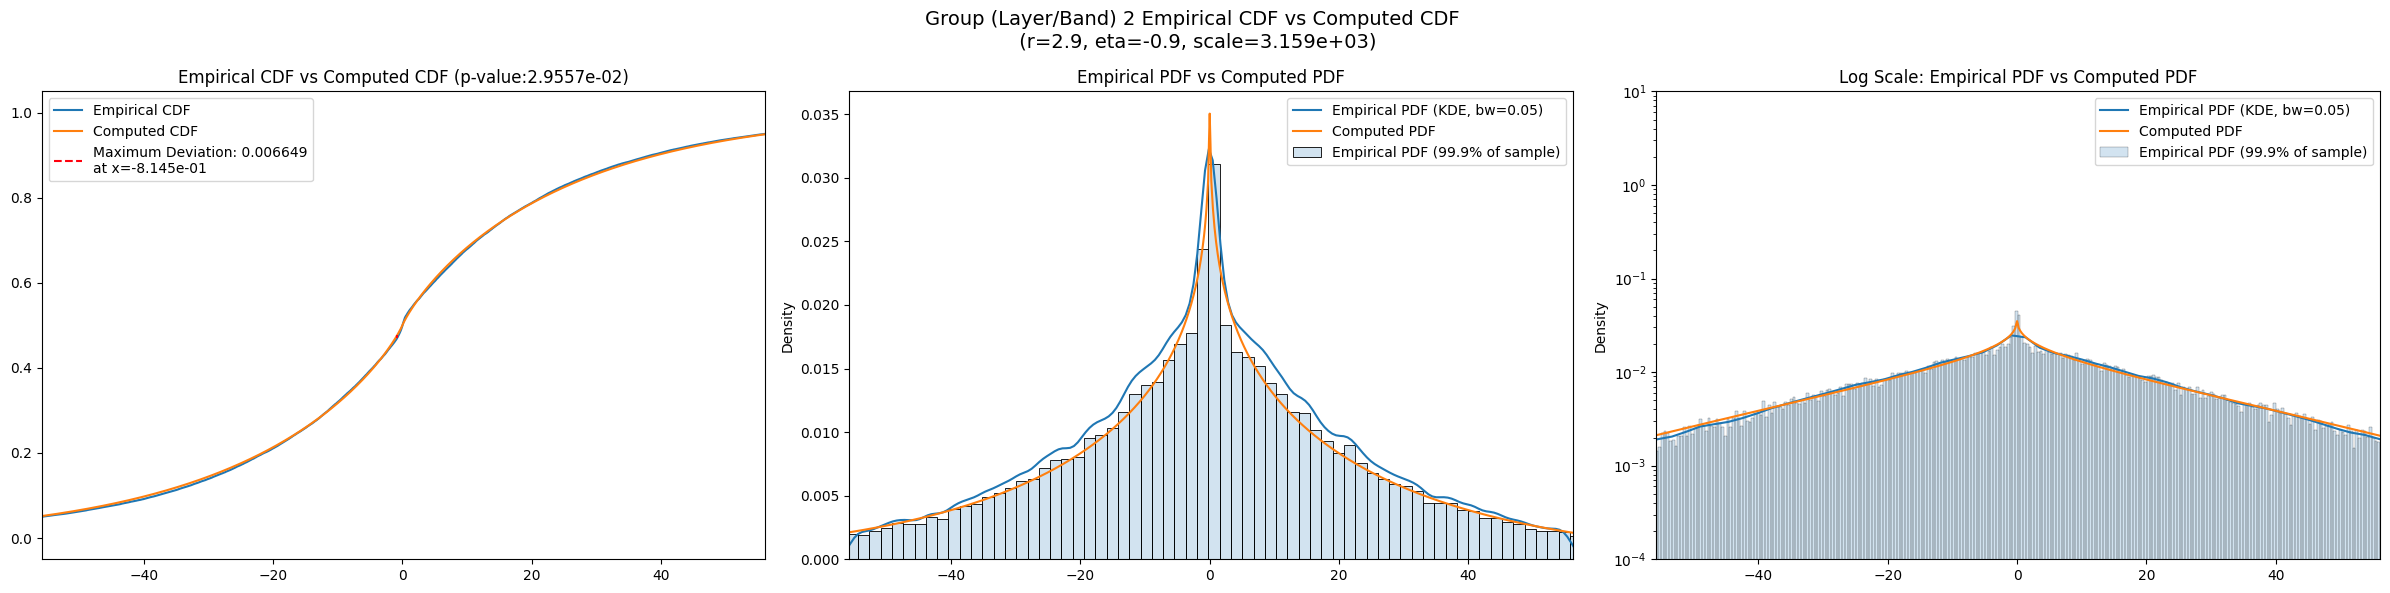

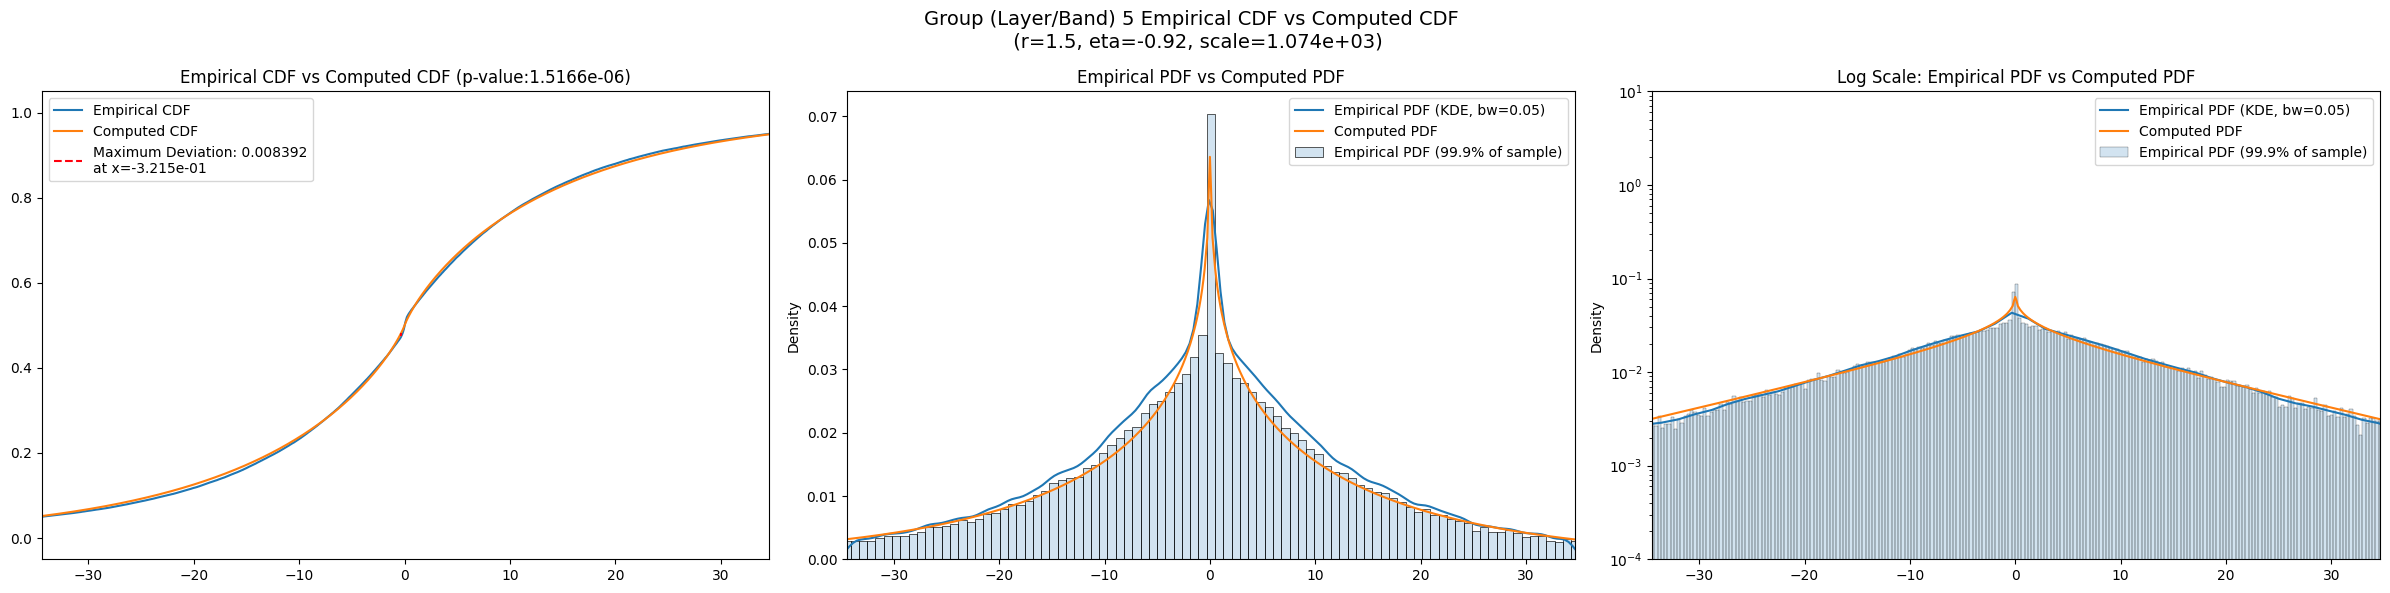

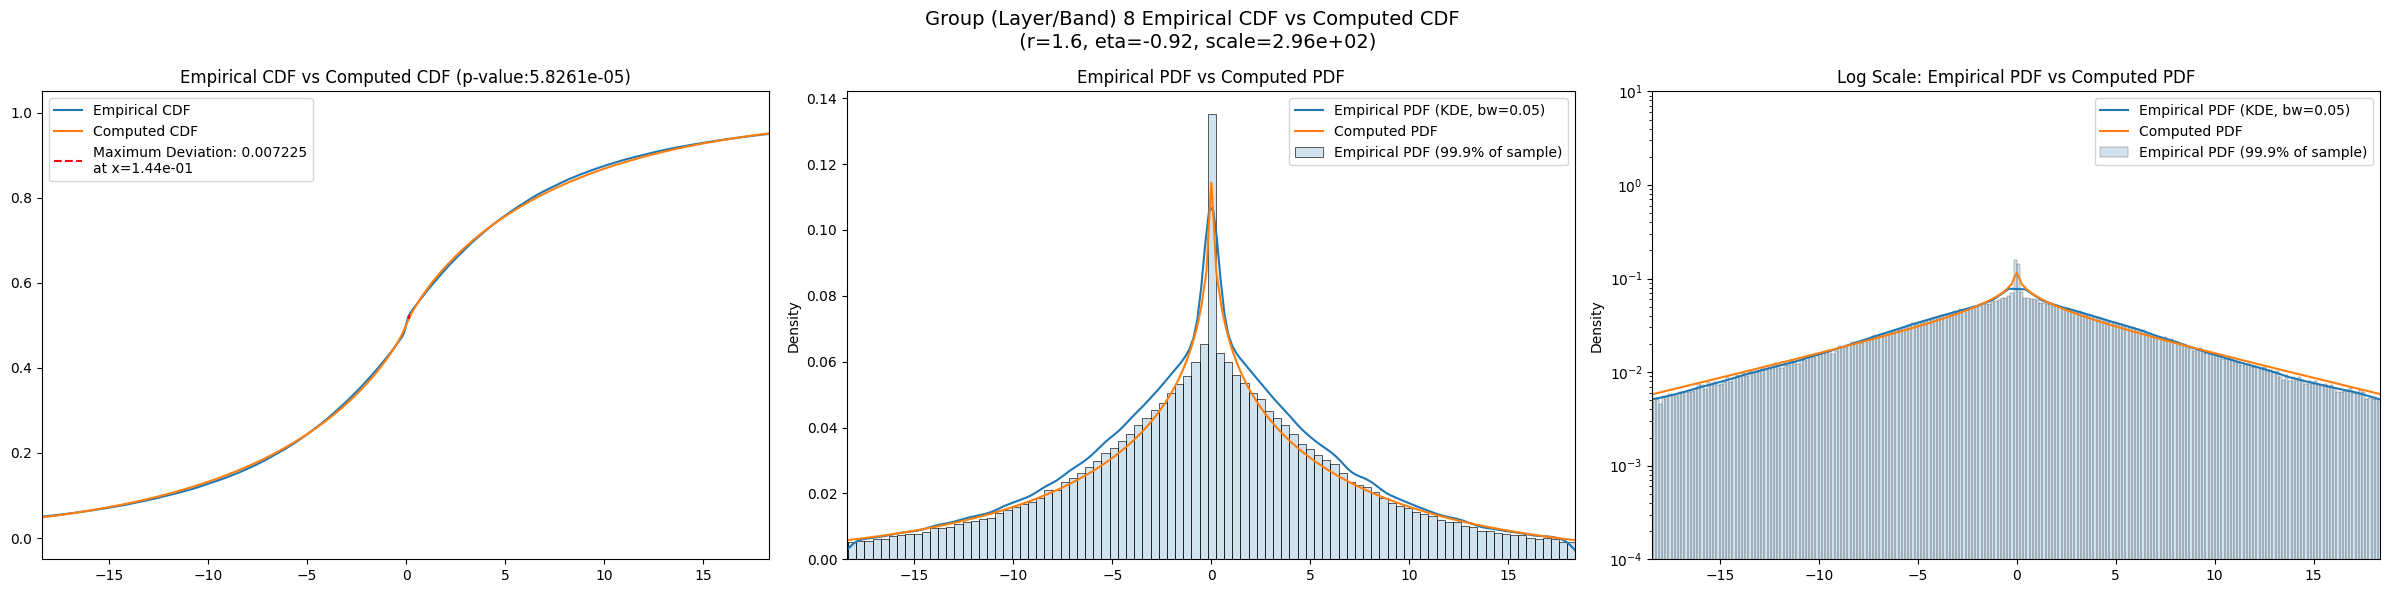

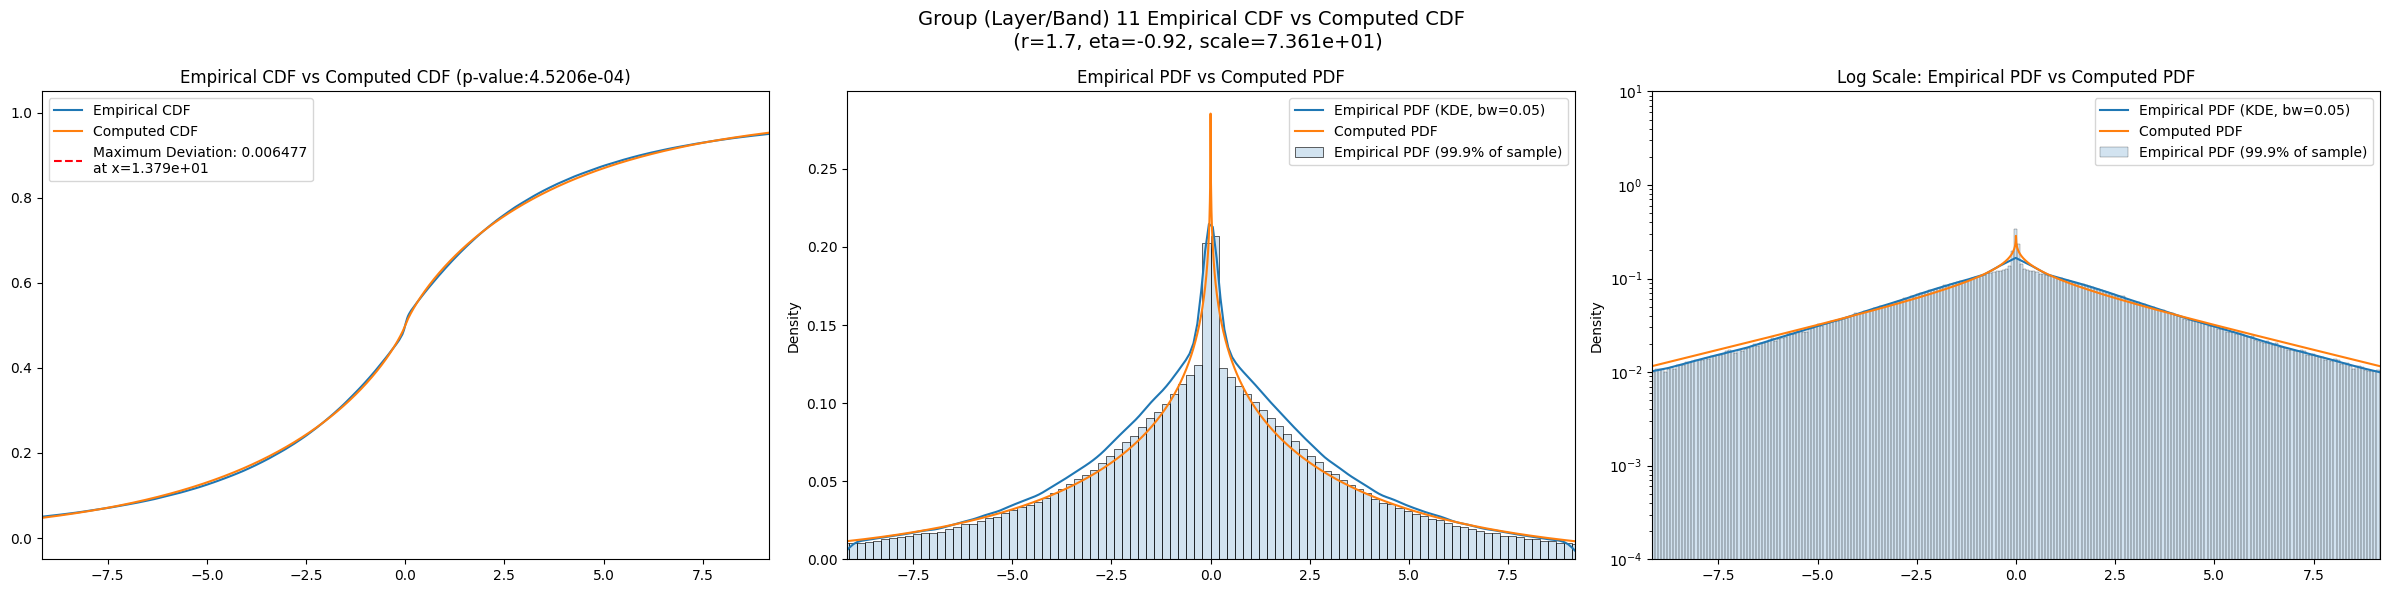

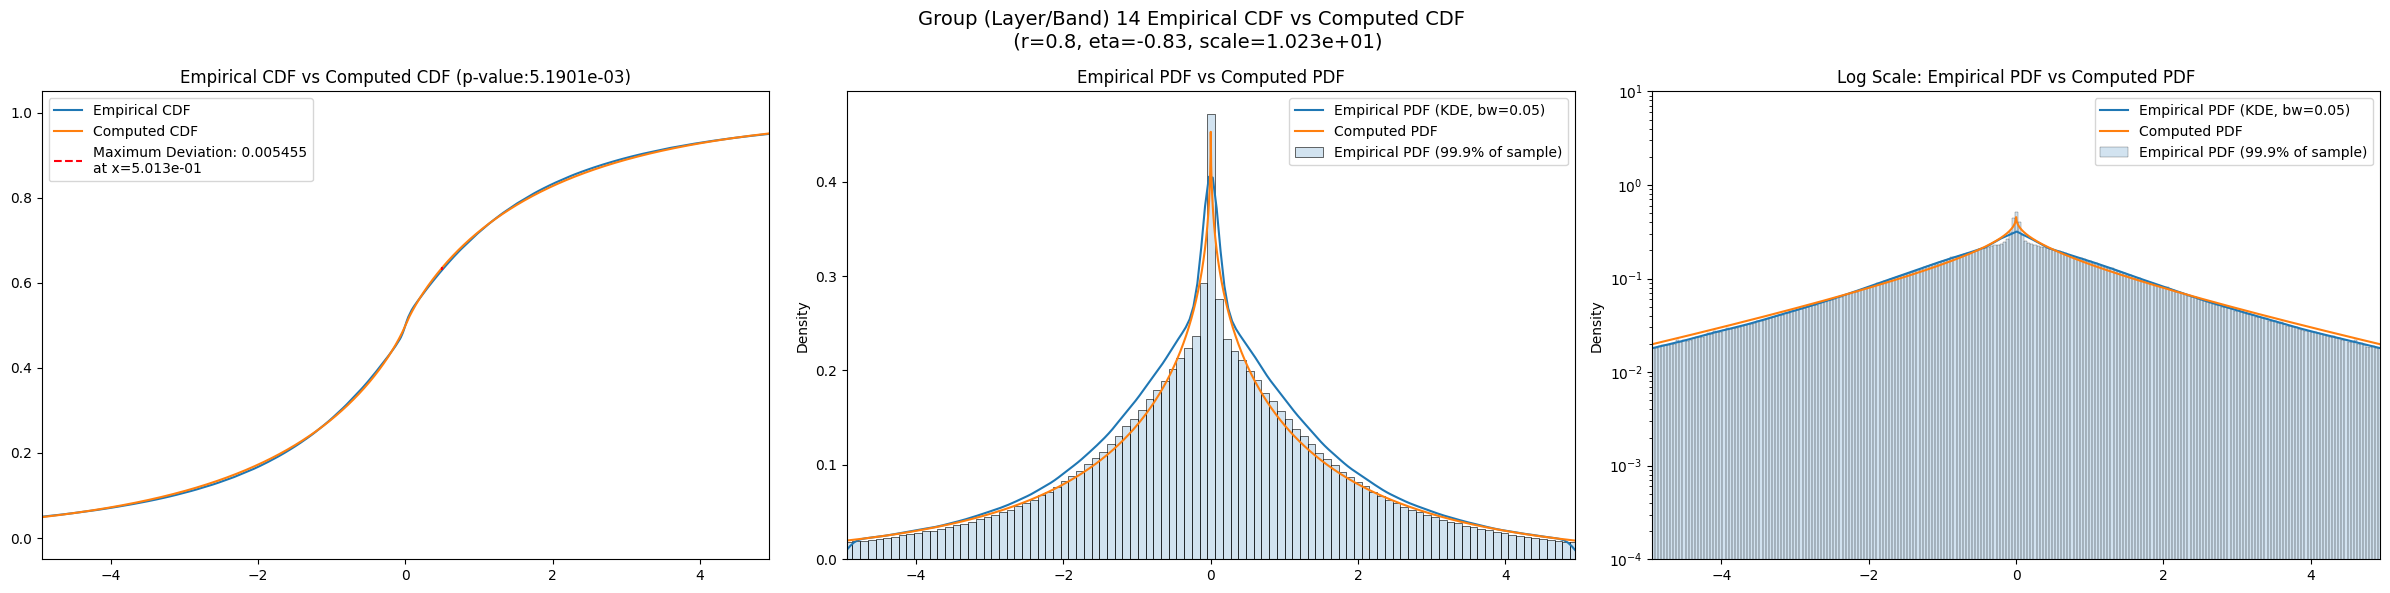

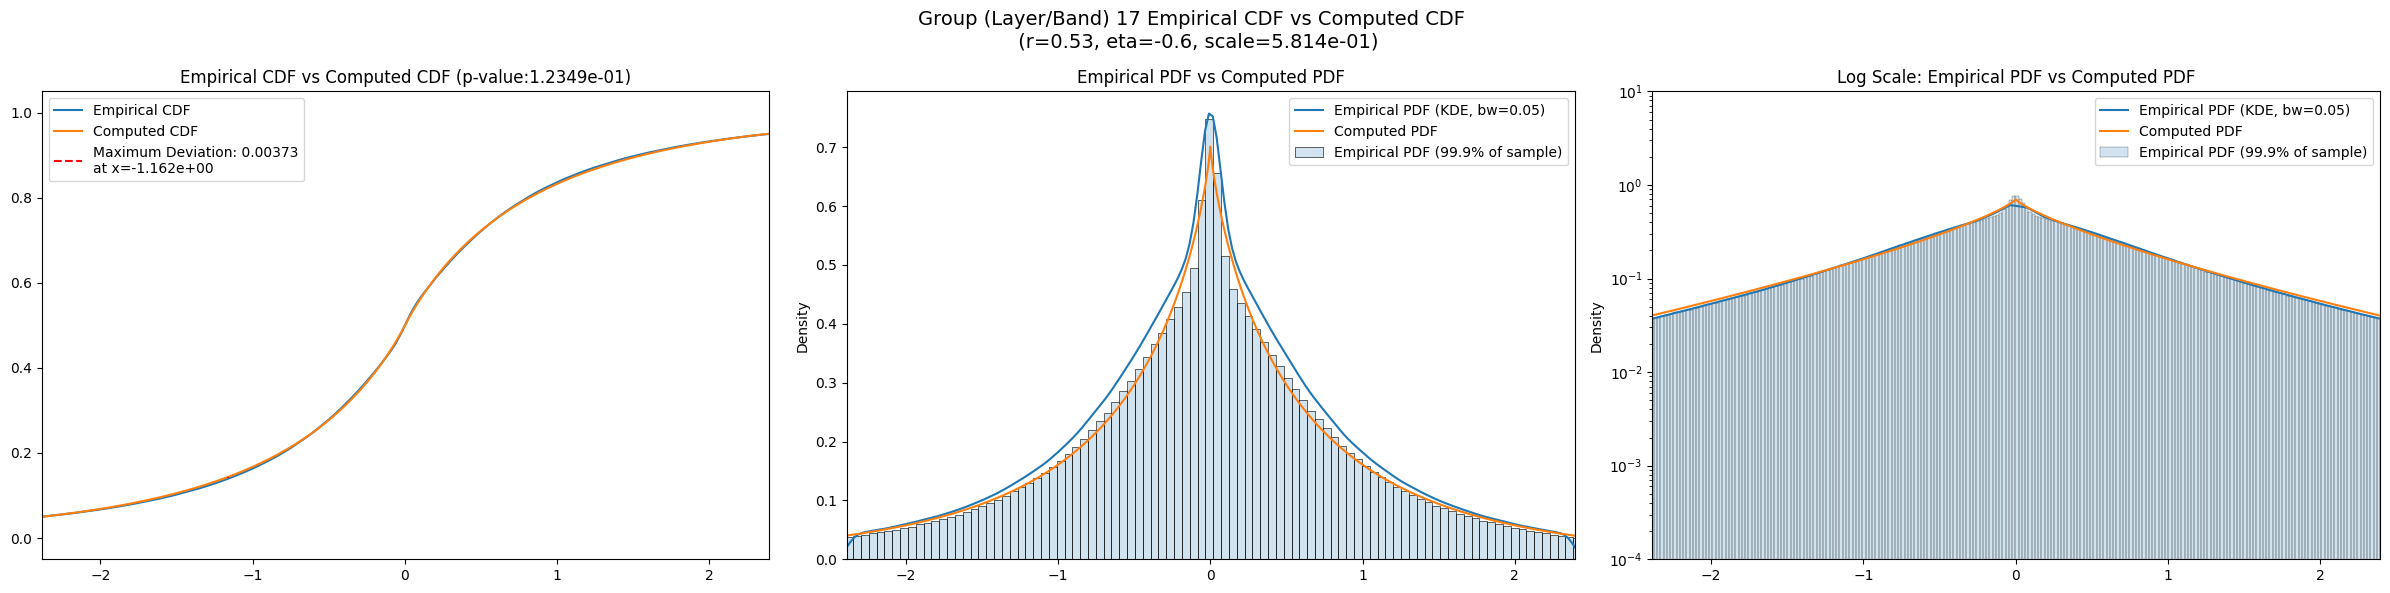

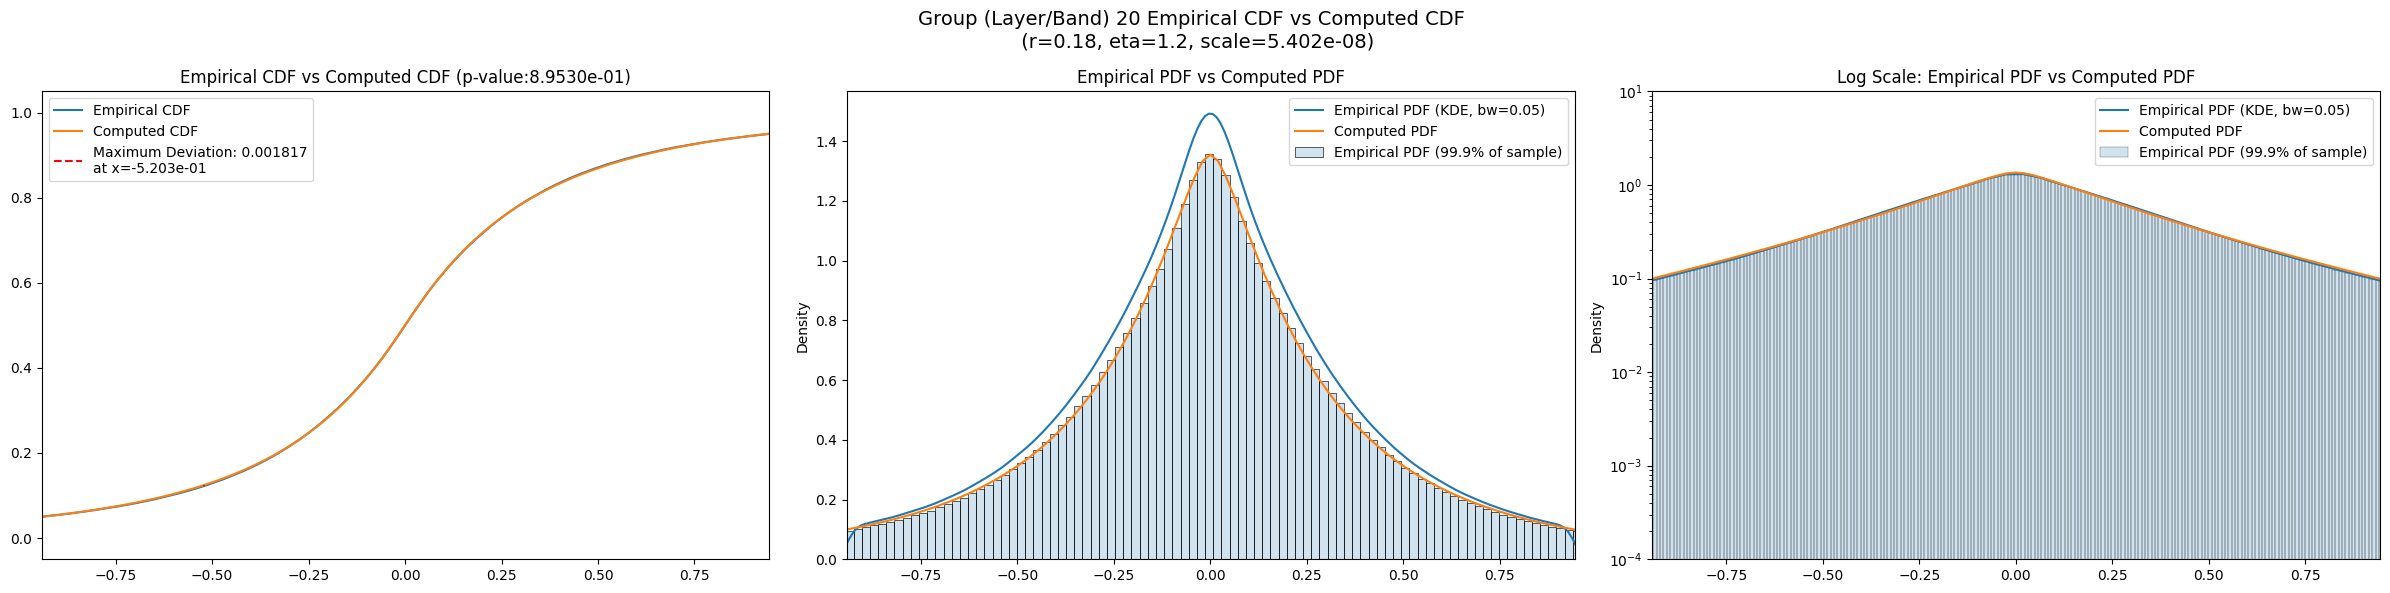

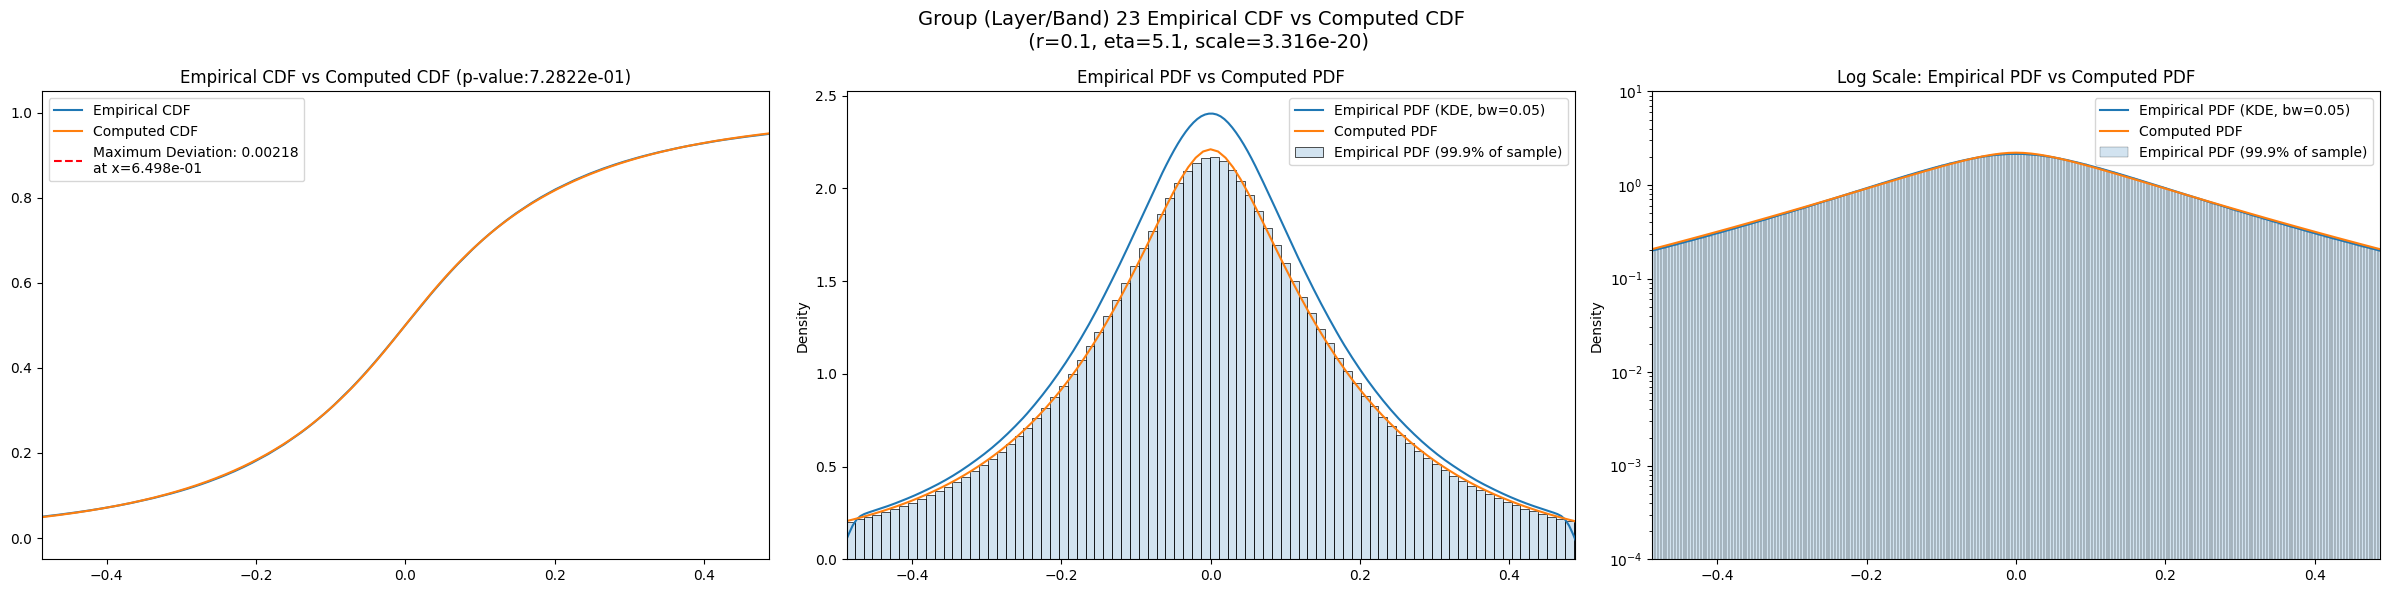

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1313.120000  1220.493700  1412.585300    6.068365    4.379918   
5      533.579040   487.300300   586.624450   10.865308    6.509176   
8      152.255700   138.976060   167.494960   10.892404    6.435522   
11      37.265316    34.162117    40.700905    9.679420    6.116399   
14      10.825041     9.897249    11.943296   11.137888    6.328707   
17       2.667430     2.387082     3.338226   39.640400    7.007048   
20       0.443403     0.378769     0.739939  218.225190    7.204465   
23       0.105539     0.095510     0.133839   39.834950    4.945594   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       8.609890        47614.0             0.006649        2.9         -0.9   
5      17.420868       102030.0             0.008698        1.2         -0.9   
8      23.173120       326496.0             0.007617        1.3         -0.9   
11     17.178192       904666.0             0.006765        1.4         -0.9   
14     29.539549      2727602.0             0.005587        0.7         -0.8   
17    239.846470      8298440.0             0.004569        0.4         -0.4   
20    976.404540     25140192.0             0.001944        0.2          0.9   
23    243.447360     65734528.0             0.002180        0.1          5.1   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       26.463100              0.034617          5.222180e-50   
5     ...       15.652700              0.038228         5.481430e-130   
8     ...        8.266470              0.038312          0.000000e+00   
11    ...        4.101910              0.038631          0.000000e+00   
14    ...        2.146880              0.041207          0.000000e+00   
17    ...        1.050460              0.040208          0.000000e+00   
20    ...        0.428743              0.036982          0.000000e+00   
23    ...        0.236131              0.031006          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         22.220700             0.012757         3.690330e-07  18.615400   
5         13.143900             0.014918         3.747500e-20  10.833800   
8          7.047450             0.013848         8.227660e-55   5.717720   
11         3.513780             0.013985        4.105210e-154   2.825210   
14         1.881440             0.014615         0.000000e+00   1.476410   
17         0.927141             0.013310         0.000000e+00   0.725234   
20         0.378319             0.010971         0.000000e+00   0.301651   
23         0.204897             0.006710         0.000000e+00   0.167349   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.017211   1.109580e-12          2.955758e-02  
5          0.018310   3.835010e-30          1.164539e-06  
8          0.016343   3.542640e-76          1.908243e-15  
11         0.016495  3.045200e-214          2.154947e-33  
14         0.017274   0.000000e+00          6.471623e-71  
17         0.015791   0.000000e+00         1.091262e-100  
20         0.009836   0.000000e+00          1.519858e-72  
23         0.005083   0.000000e+00         8.360175e-272  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.006649                 0.006220          0.006649   
5                0.008698                 0.004250          0.008386   
8                0.007617                 0.002376          0.007277   
11               0.006765                 0.001428          0.006477   
14               0.005587                 0.000822          0.005455   
17               0.004569                 0.000471          0.003730   
20               0.001944                 0.000271          0.001817   
23               0.002180                 0.000168          0.002180   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.034617             0.012757       0.017211  
5                 0.038228             0.014918       0.018310  
8                 0.038312             0.013848       0.016343  
11                0.038631             0.013985       0.016495  
14                0.041207             0.014615       0.017274  
17                0.040208             0.013310       0.015791  
20                0.036982             0.010971       0.009836  
23                0.031006             0.006710       0.005083

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2            1149.377400          0.006649    2.90     -0.90  3.159379e+03   
5             454.267731          0.008386    1.50     -0.92  1.073501e+03   
8             121.444603          0.007277    1.60     -0.92  2.959715e+02   
11             29.449203          0.006477    1.70     -0.92  7.361420e+01   
14              9.461452          0.005455    0.80     -0.83  1.022932e+01   
17              2.338931          0.003730    0.53     -0.60  5.813957e-01   
20              0.395685          0.001817    0.18      1.20  5.401900e-08   
23              0.099757          0.002180    0.10      5.10  3.316358e-20   

      best_exclude_cutoff  
band                       
2                   100.0  
5                   175.0  
8                   325.0  
11                  375.0  
14                  150.0  
17                  100.0  
20                   25.0  
23                   25.0

In [22]:
eng.quit()